In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stat
import statsmodels.api as sm

from pandas_datareader import data
from matplotlib.ticker import FuncFormatter 
from scipy.stats import norm
%matplotlib inline
# %matplotlib widget

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
close_df = pd.read_csv('/content/drive/MyDrive/btc_usd_prices.csv')

In [ ]:
from datetime import datetime
today = datetime.today().strftime('%Y-%m-%d')

In [ ]:
start_date = '2014-01-01'
end_date = '2020-12-31'
end_date = today

In [ ]:
ticker = ['BTC-USD']
panel_data = data.DataReader(ticker, 'yahoo', start_date, end_date)

#get the close price
close_df = panel_data['Close']

/usr/local/lib/python3.7/dist-packages/pandas_datareader/base.py:272: SymbolWarning: Failed to read symbol: 'BTC-USD', replacing with NaN.
  warnings.warn(msg.format(sym), SymbolWarning)


RemoteDataError: ignored

In [9]:
close_df.set_index('Date',inplace = True)

In [10]:
close_df.shape

(647, 1)

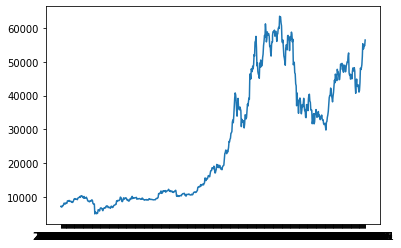

In [11]:
plt.plot(close_df)

In [12]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
close_df=scaler.fit_transform(np.array(close_df).reshape(-1,1))

In [13]:
close_df.shape

(647, 1)

In [14]:
training_size=int(len(close_df)*0.65)
test_size=len(close_df)-training_size
train_data,test_data=close_df[0:training_size,:],close_df[training_size:len(close_df),:1]

In [15]:
training_size,test_size

(420, 227)

In [16]:
import numpy

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
        
    return numpy.array(dataX), numpy.array(dataY)
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [17]:
X_train.shape, y_train.shape

((319, 100), (319,))

In [18]:
X_test.shape, ytest.shape

((126, 100), (126,))

In [19]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [20]:
X_train.shape , X_test.shape

((319, 100, 1), (126, 100, 1))

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [22]:
model= Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [24]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size = 64,verbose =1)

Epoch 1/100
5/5 [==============================] - 7s 475ms/step - loss: 0.0436 - val_loss: 0.0091
Epoch 2/100
5/5 [==============================] - 1s 186ms/step - loss: 0.0155 - val_loss: 0.0065
Epoch 3/100
5/5 [==============================] - 1s 183ms/step - loss: 0.0066 - val_loss: 0.0243
Epoch 4/100
5/5 [==============================] - 1s 187ms/step - loss: 0.0067 - val_loss: 0.0138
Epoch 5/100
5/5 [==============================] - 1s 186ms/step - loss: 0.0039 - val_loss: 0.0496
Epoch 6/100
5/5 [==============================] - 1s 188ms/step - loss: 0.0027 - val_loss: 0.0064
Epoch 7/100
5/5 [==============================] - 1s 183ms/step - loss: 0.0030 - val_loss: 0.0098
Epoch 8/100
5/5 [==============================] - 1s 186ms/step - loss: 0.0023 - val_loss: 0.0264
Epoch 9/100
5/5 [==============================] - 1s 183ms/step - loss: 0.0023 - val_loss: 0.0072
Epoch 10/100
5/5 [==============================] - 1s 188ms/step - loss: 0.0022 - val_loss: 0.0065
Epoch 11/

In [25]:

### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [29]:

##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

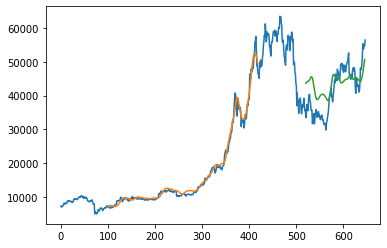

In [30]:

### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(close_df)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(close_df)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(close_df)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(close_df))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [34]:

x_input=test_data[127:].reshape(1,-1)
x_input.shape

(1, 100)

In [35]:

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [37]:
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.80609894]
101
1 day input [0.49160949 0.49996707 0.49347724 0.47676936 0.49249802 0.48775721
 0.50005236 0.48152698 0.47377367 0.47582931 0.45803383 0.45189723
 0.45380265 0.45830855 0.44158321 0.42431962 0.46367107 0.46712918
 0.4887999  0.50094516 0.51901613 0.55296893 0.58832365 0.5983858
 0.59859963 0.63664889 0.62623844 0.59802683 0.5848214  0.56690038
 0.59414198 0.61331163 0.64657417 0.67628921 0.66334459 0.70720531
 0.69387308 0.6940201  0.67411074 0.73160054 0.71970334 0.71885012
 0.70103921 0.6786735  0.68048152 0.71322205 0.75801067 0.75060141
 0.75771129 0.76154669 0.73011072 0.75154613 0.71705992 0.75321834
 0.75054863 0.7493088  0.71898646 0.72089485 0.74960257 0.757815
 0.76973403 0.76835445 0.7992566  0.81429308 0.71482031 0.70252396
 0.70764984 0.68189479 0.68731991 0.70204353 0.68324727 0.71962726
 0.73814436 0.73143036 0.72261751 0.73988725 0.72249278 0.64704059
 0.61030683 0.65952434 0.68208592 0.64697139 0.64486733 0.65327195
 0.63665203 0.61613037 0.62518207 0.

In [38]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [39]:
len(close_df)

647

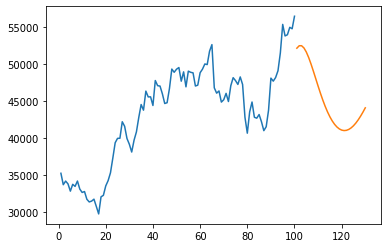

In [45]:

plt.plot(day_new,scaler.inverse_transform(close_df[547:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

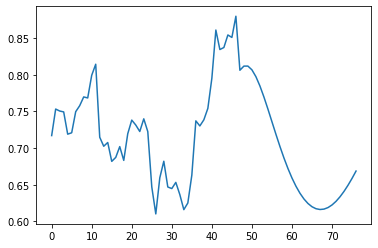

In [47]:
df3=close_df.tolist()
df3.extend(lst_output)
plt.plot(df3[600:])

In [48]:
df3=scaler.inverse_transform(df3).tolist()

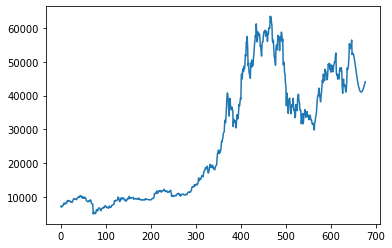

In [49]:
plt.plot(df3)


In [56]:
df3[-1]

[44111.81986594852]

In [55]:
close_df

array([[3.79755626e-02],
       [3.80878964e-02],
       [3.44197892e-02],
       [4.05601903e-02],
       [4.16838784e-02],
       [4.16951651e-02],
       [4.78097309e-02],
       [5.45490980e-02],
       [5.31169134e-02],
       [4.96864957e-02],
       [5.45979907e-02],
       [5.23938096e-02],
       [5.50411610e-02],
       [5.42159841e-02],
       [6.58944250e-02],
       [6.55398554e-02],
       [6.41180065e-02],
       [6.76246286e-02],
       [6.78598905e-02],
       [6.38183274e-02],
       [6.29879785e-02],
       [6.44957169e-02],
       [6.33849089e-02],
       [5.86976060e-02],
       [5.93625158e-02],
       [5.80369840e-02],
       [6.19490288e-02],
       [6.72962863e-02],
       [7.49632955e-02],
       [7.42464315e-02],
       [7.75328575e-02],
       [7.48255853e-02],
       [7.55490394e-02],
       [7.47202755e-02],
       [7.38516366e-02],
       [7.19286320e-02],
       [7.93170007e-02],
       [8.13052567e-02],
       [8.24352513e-02],
       [8.36170833e-02],
